In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

from fastai.imports import *
from fastai.conv_learner import *
from fastai.transforms import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from torch import nn
import torch.nn.functional as F
from callback import *
from sklearn.metrics import fbeta_score
from sklearn.model_selection import KFold

IMG_PATH = 'train-jpg/'
LBL_PATH = 'train_v2.csv'
n_classes = 17
stats = [[0,0,0], [255.,255.,255.]]

sz = 256
bs=32

val_idxs = get_cv_idxs(len(os.listdir(IMG_PATH)))

def f2(preds, y):
    ret = fbeta_score(y, preds>0.2, beta=2, average='samples')
    return ret

def get_data(sz, val_idxs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_csv('.', 'train-jpg', 'train_v2.csv',bs, tfms, 
                                        val_idxs=val_idxs, 
                                        suffix='.jpg',
                                        test_name='test-jpg')
    return data

def get_model(data):
    custom_head = nn.Sequential(nn.AdaptiveAvgPool2d(1), 
                            Flatten(),
                            nn.Linear(512, n_classes),
                            nn.Sigmoid())

    model = ConvnetBuilder(resnet34, 0,0,0,custom_head=custom_head)

    # learn = ConvLearner.from_model_data(model, get_data(sz), metrics=[f2])
    learn = ConvLearner(data, model, metrics=[f2])
    
    return learn

def predict(learn, k):
    pred,y =learn.TTA(is_test=True)
    pred = np.mean(pred, 0)

#     c = np.array(learn.data.classes)

#     label_text = np.array([' '.join(c[p>thres_opt]) for p in pred])

#     df = pd.DataFrame({'image_name': [f[9:-4] for f in learn.data.test_ds.fnames], 
#                        'tags': label_text})
    df = pd.DataFrame(pred, columns=learn.data.classes)
    df.insert(0, 'id', [f[9:-4] for f in learn.data.test_ds.fnames])

    df.to_csv('pred'+str(k)+'.csv', index=False)
    
def train(learn, k):
    lr=1e-2
    lrs=[lr/10,lr/4,lr]
    learn.fit(lrs, 2, cycle_len = 8, use_clr=(20, 8), 
              callbacks=[SaveBestModel(learn, lrs, 'kfold'+str(k), monitor='loss', patience=16)])
    return learn

epoch      trn_loss   val_loss   f2                            
    0      0.444412   5.575397   0.433133  



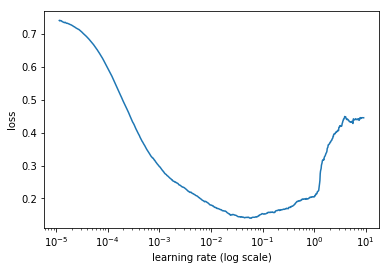

In [2]:
learn.lr_find()
learn.sched.plot()

In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=2018)
k=0
for trn_idxs, val_idxs in kf.split(np.zeros((len(os.listdir(IMG_PATH)),1))):
    print('.............', k,'.....fold')
    data = get_data(sz, val_idxs)
    learn = get_model(data)
    learn.fit(1e-2, 1, cycle_len=1)
    learn.unfreeze()
    learn = train(learn, k)
    predict(learn, k)
    k+=1

............. 0 .....fold


epoch      trn_loss   val_loss   f2                            
    0      0.256544   0.253968   0.673847  


epoch      trn_loss   val_loss   f2                            
    0      0.132514   0.118534   0.897166  
    1      0.113256   0.10321    0.911961                      
    2      0.104213   0.098381   0.914779                      
    3      0.103627   0.095115   0.918158                      
    4      0.096733   0.093459   0.919798                       
    5      0.10072    0.092655   0.920587                       
    6      0.100823   0.091868   0.920895                       
    7      0.092953   0.091207   0.922014                       
    8      0.097583   0.091936   0.919787                       
    9      0.094807   0.091318   0.920591                       
    10     0.095712   0.090194   0.921005                       
    11     0.093739   0.0883     0.923795                       
    12     0.092181   0.088261   0.924604                       
    13     0.089214   0.087655   0.925121                       
    14     0.089447   0.08758    0.92526          

epoch      trn_loss   val_loss   f2                            
    0      0.255947   0.253841   0.672842  


epoch      trn_loss   val_loss   f2                            
    0      0.127007   0.117631   0.897794  
    1      0.109148   0.102938   0.910481                      
    2      0.107953   0.09949    0.913313                      
    3      0.101208   0.094767   0.917374                      
    4      0.104546   0.093717   0.917726                      
    5      0.101446   0.092544   0.91935                        
    6      0.092934   0.091883   0.919544                       
    7      0.098599   0.091482   0.920345                       
    8      0.096056   0.093303   0.918359                       
    9      0.095908   0.090628   0.920932                       
    10     0.094193   0.090565   0.92161                        
    11     0.089324   0.08937    0.920851                       
    12     0.093638   0.089008   0.921253                       
    13     0.091082   0.087985   0.922583                       
    14     0.088883   0.088241   0.921598          

epoch      trn_loss   val_loss   f2                            
    0      0.255034   0.258673   0.668454  


epoch      trn_loss   val_loss   f2                            
    0      0.130822   0.121074   0.89357   
    1      0.110801   0.103898   0.909686                      
    2      0.101972   0.099962   0.914481                      
    3      0.104751   0.096353   0.918122                      
    4      0.099047   0.094878   0.918886                       
    5      0.099015   0.094182   0.918837                       
    6      0.098558   0.093432   0.918613                       
    7      0.097903   0.092535   0.920363                       
    8      0.100024   0.094352   0.9184                         
    9      0.093811   0.092591   0.920131                       
    10     0.091879   0.091495   0.920322                       
    11     0.092459   0.09046    0.923203                       
    12     0.089997   0.089457   0.922987                       
    13     0.089741   0.089474   0.923514                       
    14     0.087531   0.08891    0.923971         

epoch      trn_loss   val_loss   f2                            
    0      0.259281   0.257582   0.669282  


epoch      trn_loss   val_loss   f2                            
    0      0.128454   0.123036   0.892157  
    1      0.10774    0.106465   0.909147                      
    2      0.105461   0.100756   0.913821                      
    3      0.104022   0.097835   0.916015                      
    4      0.094734   0.097361   0.915797                       
    5      0.095948   0.094834   0.918136                       
    6      0.097899   0.09439    0.918754                       
    7      0.09865    0.093968   0.920015                       
    8      0.096524   0.094418   0.918225                       
    9      0.097744   0.09322    0.917643                       
    10     0.092337   0.092991   0.920249                       
    11     0.08899    0.090999   0.920808                       
    12     0.090738   0.090505   0.921896                       
    13     0.09174    0.090069   0.922689                       
    14     0.085933   0.090042   0.922717         

epoch      trn_loss   val_loss   f2                            
    0      0.258828   0.255052   0.670912  


epoch      trn_loss   val_loss   f2                            
    0      0.133169   0.12022    0.889169  
    1      0.111063   0.104558   0.905339                      
    2      0.108138   0.099358   0.913613                      
    3      0.104269   0.097427   0.914907                      
    4      0.099144   0.094823   0.917689                       
    5      0.097208   0.094427   0.917134                       
    6      0.098132   0.093463   0.91775                        
    7      0.098663   0.093199   0.918314                       
    8      0.102095   0.095213   0.914235                       
    9      0.094015   0.091813   0.918192                       
    10     0.092426   0.090864   0.919757                       
    11     0.08989    0.090773   0.919498                       
    12     0.086841   0.090016   0.920433                       
    13     0.090253   0.090358   0.920355                       
    14     0.089906   0.090245   0.919273         

In [13]:
df0 = pd.read_csv('pred0.csv')
df1 = pd.read_csv('pred1.csv')
df2 = pd.read_csv('pred2.csv')
df3 = pd.read_csv('pred3.csv')
df4 = pd.read_csv('pred4.csv')

In [14]:
df0.head(3)

,id,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,test_38090,0.004727,0.000006,0.000214,0.002876,0.000732,0.999831,0.000002,0.000012,0.001792,0.000146,0.000165,0.000141,0.999983,0.001612,0.000711,0.000050,0.004315
1,file_7133,0.800215,0.002711,0.073661,0.015873,0.012992,0.988271,0.000209,0.002608,0.325240,0.189296,0.001785,0.016481,0.996693,0.364780,0.039451,0.034109,0.379386
2,file_189,0.466742,0.000533,0.012968,0.000916,0.000544,0.906671,0.000140,0.000536,0.271680,0.067639,0.062387,0.021662,0.998766,0.511500,0.006371,0.001941,0.912991


In [17]:
df1.head(3)

,id,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,test_38090,0.000600,4.883465e-07,0.000013,0.005012,0.000332,0.999893,0.000002,0.000002,0.000549,0.000049,0.000035,0.000055,0.999993,0.000080,0.000270,0.000009,0.000201
1,file_7133,0.788766,6.390858e-03,0.082785,0.020504,0.020875,0.987569,0.000389,0.004241,0.389950,0.136741,0.004185,0.012933,0.998423,0.269351,0.041187,0.055626,0.267767
2,file_189,0.393614,8.968714e-04,0.013738,0.002528,0.002586,0.941730,0.000211,0.001133,0.283970,0.053305,0.032129,0.010977,0.998734,0.496238,0.012688,0.004623,0.727856


In [37]:
df = df0.drop(['id'],axis=1)

In [38]:
dfs=[df1,df2,df3,df4]
for i in range(4):
    df += dfs[i].drop(['id'],axis=1)
df = df / 5

In [39]:

df.head(3)

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.002341,0.000002,0.000116,0.003349,0.000372,0.999671,0.000003,0.000005,0.001374,0.000178,0.000114,0.000173,0.999988,0.000655,0.000477,0.000021,0.001622
1,0.812595,0.002912,0.064228,0.013822,0.019924,0.989033,0.000212,0.003115,0.375922,0.162836,0.002701,0.011726,0.997921,0.297046,0.034870,0.043097,0.284184
2,0.442796,0.000789,0.013488,0.001359,0.001171,0.933547,0.000127,0.000896,0.260054,0.094133,0.057215,0.013577,0.998687,0.568704,0.009136,0.002718,0.864521


In [40]:
df.values

array([[0.00234, 0.     , 0.00012, ..., 0.00048, 0.00002, 0.00162],
       [0.8126 , 0.00291, 0.06423, ..., 0.03487, 0.0431 , 0.28418],
       [0.4428 , 0.00079, 0.01349, ..., 0.00914, 0.00272, 0.86452],
       ...,
       [0.00016, 0.     , 0.00001, ..., 0.00004, 0.     , 0.00025],
       [0.02268, 0.00026, 0.00123, ..., 0.00183, 0.00162, 0.02422],
       [0.2939 , 0.00013, 0.00576, ..., 0.00113, 0.00216, 0.99811]])

In [41]:
c = np.array(learn.data.classes)

label_text = np.array([' '.join(c[p>thres_opt]) for p in df.values])

df_csv = pd.DataFrame({'image_name': [f[9:-4] for f in learn.data.test_ds.fnames], 
                   'tags': label_text})

In [42]:
df_csv.to_csv('subm.csv', index=False)

In [34]:
thres_opt=[0.17, 0.32,0.19,0.27,0.17, 0.15,0.1,0.27,0.19,0.16,0.17,0.16,0.3,0.2,0.16,0.17,0.18]

In [36]:
df.values.shape

(61191, 2)